In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Configure Logger

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch 
import numpy as np 
from src.keypoint_utils import gaussian_heatmap, generate_keypoints_heatmap, get_keypoints_from_heatmap
from src.models import KeypointDetector
from src.datamodule import BoxKeypointsDataModule, BoxKeypointsDataset


In [4]:

wandb_logger = WandbLogger(project="test-project", entity="airo-box-manipulation")

In [5]:
!nvidia-smi

Fri Nov  5 21:11:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P3    N/A /  N/A |    729MiB /  4042MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
torch.cuda.is_available()

True

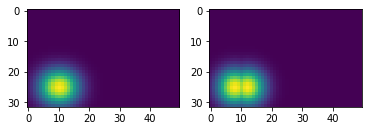

In [7]:
## Demonstration on why one should use max(.) instead of sum to combine the keypoints
# sum wil make 1 blob of 2 neighbouring keypoints
# furthermore it will also reduce the 
img = gaussian_heatmap((32,50),(8,25),torch.Tensor([4]))
img2 = gaussian_heatmap((32,50),(12,25),torch.Tensor([4]))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img  +img2)
axarr[1].imshow(torch.max(img, img2))

In [8]:
IMAGE_DATASET_PATH = "/workspaces/box-manipulation/datasets/box_dataset2"
JSON_PATH = "/workspaces/box-manipulation/datasets/box_dataset2/dataset.json"

In [9]:
def imshow(img):
    """
    plot Tensor as image
    images are kept in the [0,1] range, although in theory [-1,1] should be used to whiten..
    """
    np_img = img.numpy()
    # bring (C,W,H) to (W,H,C) dims
    img = np.transpose(np_img, (1,2,0))
    plt.imshow(img)
    plt.show()


In [10]:
def show_heatmap_overlay(img, heatmap):
    """
    plot Tensors of heatmap and image on same figure 
    """
    fig, ax = plt.subplots()  #create figure and axes
    img = img.numpy()
    img = np.transpose(img, (1,2,0))
    ax.imshow(img, alpha= 0.9)
    ax.imshow(heatmap.numpy(), alpha = 0.2)
    plt.show()

In [11]:


module = BoxKeypointsDataModule(BoxKeypointsDataset(JSON_PATH, IMAGE_DATASET_PATH),2)
batch = next(iter(module.train_dataloader()))
#print(batch)
print(batch[0].shape)
print(batch[1].shape)

torch.Size([2, 3, 256, 256])
torch.Size([2, 4, 2])


torch.Size([1, 1, 180, 180])
KeypointDetector(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(2, 2))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(4, 4))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(8, 8))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(16, 16))
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), paddin

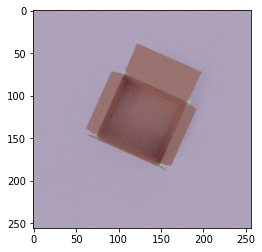

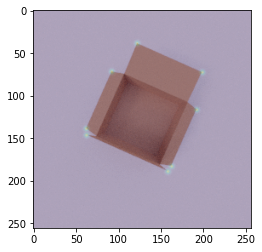

In [14]:
model = KeypointDetector(heatmap_sigma= 2)
dummy_input = torch.rand((1,3,180,180))

output = model(dummy_input)
print(output.shape)
print(model)

module = BoxKeypointsDataModule(BoxKeypointsDataset(JSON_PATH, IMAGE_DATASET_PATH),2)
batch = next(iter(module.train_dataloader()))
imgs, corner_keypoints, flap_keypoints = batch 
print(imgs[0].shape[1:])
print(imgs.shape)

heatmaps = model.create_heatmap_batch(imgs[0].shape[1:],corner_keypoints)
flap_heatmaps = model.create_heatmap_batch(imgs[0].shape[1:], flap_keypoints)
print(heatmaps.shape)
show_heatmap_overlay(imgs[0],heatmaps[0])
show_heatmap_overlay(imgs[0],flap_heatmaps[0])

In [15]:
pl.seed_everything(2021, workers = True) # deterministic run
model = KeypointDetector()
module = BoxKeypointsDataModule(BoxKeypointsDataset(JSON_PATH, IMAGE_DATASET_PATH),2)

trainer = pl.Trainer(max_epochs = 5, logger=wandb_logger)


Global seed set to 2021
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/conda/envs/python39/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1566: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


In [16]:
trainer.fit(model, module)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 102 K 
-------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.412     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

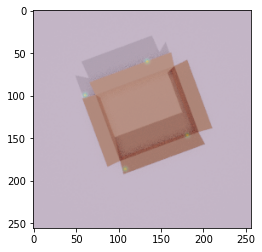

In [17]:
batch = next(iter(module.train_dataloader()))

imgs, corner_keypoints = batch 

with torch.no_grad():
    predictions = model(imgs)
    show_heatmap_overlay(imgs[0],heatmaps[0])